# Faces-HQ 

In this notebook we show the results for Faces-HQ. You can create from scratch the features or use the pre-computed ones.

### 1. Create feature

If you want to create the features, first of all download the data from [link](https://cutt.ly/6enDLYG). Be sure to save the folder together with this notebook. 

Otherwise, just jump to section 2.

In [1]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle


path = ['E:/Downloads Chrome/archive1/deepfake/1', 'E:/Downloads Chrome/archive1/deepfake/0']
labels = [1,0]
format_file = ['jpg','jpg']
epsilon = 1e-8
data = {}
#number of samples from each dataset
stop = 500
number_iter = 2 * stop
psd1D_total = np.zeros([number_iter, 156])
label_total = np.zeros([number_iter])
iter_ = 0

for z in range(2):
    cont = 0
    psd1D_average_org = np.zeros(156)
    print(path[z])
    
    for filename in glob.glob(path[z]+"/*."+format_file[z]):  
        img = cv2.imread(filename,0)
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon

        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)
        psd1D_total[iter_,:] = psd1D
        label_total[iter_] = labels[z]

        cont+=1
        iter_+=1
        if cont >= stop:
            break

data["data"] = psd1D_total
data["label"] = label_total

output = open('dataset_freq_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()
print("DATA Saved")    

E:/Downloads Chrome/archive1/deepfake/1
E:/Downloads Chrome/archive1/deepfake/0
DATA Saved


### 2. Loading Features

Now, we load the features. Either the pre-computed ones or the features that you have created.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('dataset_freq_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

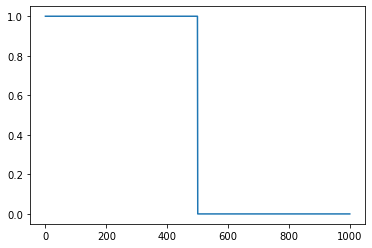

In [3]:
plt.plot(y)

### 3. Check Spectrum

We have a look to the spectrum

Text(0, 0.5, 'Power Spectrum')

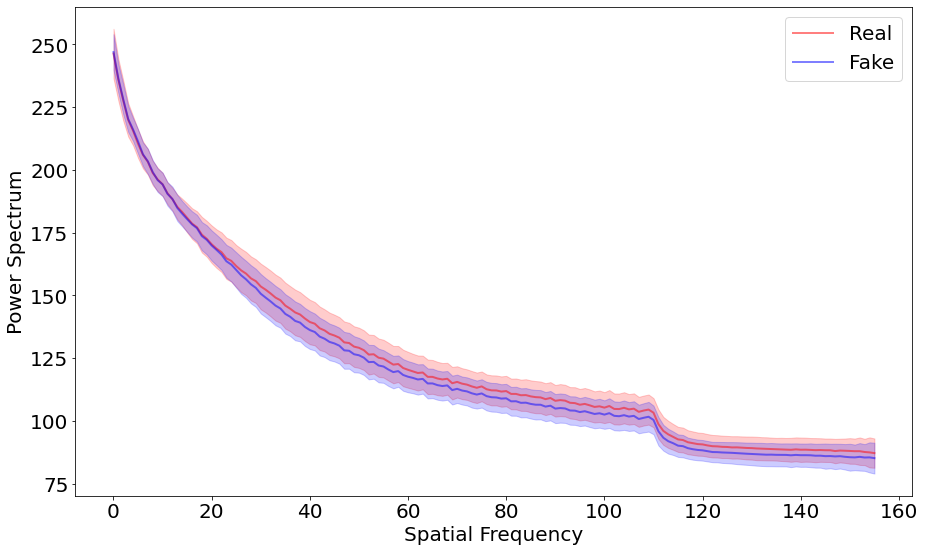

In [4]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
ax.legend()
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)

### 4. Classification

Now we classify using the features.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
LR = 0
SVM = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('dataset_freq_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]

    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=500)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

 
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average LR: "+str(LR/num))

Average SVM: 0.6880000000000001
Average LR: 0.6995000000000001


ModuleNotFoundError: No module named 'torch'